In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import os
import gc


from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from nltk.corpus import stopwords
#import distance 
from nltk.stem import PorterStemmer

from bs4 import BeautifulSoup

In [125]:
import distance

In [126]:
df=pd.read_csv("train.csv")

In [127]:
df.shape[0]

404290

In [128]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


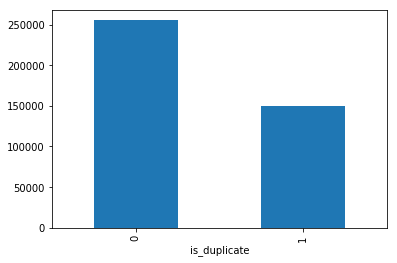

In [130]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [131]:
df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [132]:
print("Total number of question pairs for training : {}\n".format(len(df)))

Total number of question pairs for training : 404290



In [133]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
print(qids)
#qids.shape()
unique_qs=len(np.unique(qids))
qs_morethan_onetime=np.sum(qids.value_counts()>1)
print('Total number of unique questions are: {}\n'.format(unique_qs))
print('Number of Unique questions that are more than one time: {}({})\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('Max number of times a single question repeated : {}\n'.format(max(qids.value_counts())))
q_vals=qids.value_counts()
q_vals=q_vals.values

0              1
1              3
2              5
3              7
4              9
           ...  
808575    379845
808576    155606
808577    537929
808578    537931
808579    537933
Length: 808580, dtype: int64
Total number of unique questions are: 537933

Number of Unique questions that are more than one time: 111780(20.77953945937505)

Max number of times a single question repeated : 157



In [134]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


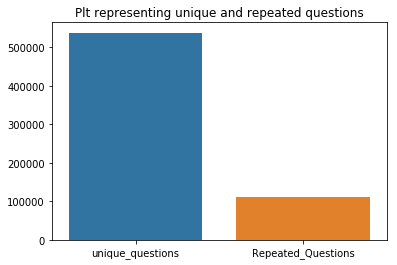

In [135]:
x=["unique_questions","Repeated_Questions"]
y=[unique_qs,qs_morethan_onetime]
plt.title("Plt representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

In [136]:
print(qids)
print(qids.value_counts())
df1=qids.to_frame()
#df1[[1]].count()

0              1
1              3
2              5
3              7
4              9
           ...  
808575    379845
808576    155606
808577    537929
808578    537931
808579    537933
Length: 808580, dtype: int64
2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64


In [137]:
pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of Duplicate questions",(pair_duplicates).shape[0]-df.shape[0])
print(pair_duplicates.shape[0])
print(df.shape[0])
print(pair_duplicates.shape)

Number of Duplicate questions 0
404290
404290
(404290, 3)


Text(0.5,0,'Number of occurence of question')

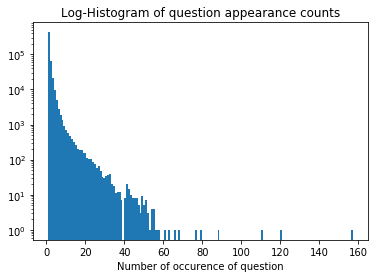

In [138]:
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log',nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurence of question')
#plt.lable('Number of questions')

In [139]:
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [140]:
df=df.fillna(' ')
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [141]:
"""
    freq_qid1 = Frequency of qid1's
    freq_qid2 = Frequency of qid2's
    q1len = Length of q1
    q2len = Length of q2
    q1_n_words = Number of words in Question 1
    q2_n_words = Number of words in Question 2
    word_Common = (Number of common unique words in Question 1 and Question 2)
    word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
    word_share = (word_common)/(word_Total)
    freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
    freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2
"""

"\n    freq_qid1 = Frequency of qid1's\n    freq_qid2 = Frequency of qid2's\n    q1len = Length of q1\n    q2len = Length of q2\n    q1_n_words = Number of words in Question 1\n    q2_n_words = Number of words in Question 2\n    word_Common = (Number of common unique words in Question 1 and Question 2)\n    word_Total =(Total num of words in Question 1 + Total num of words in Question 2)\n    word_share = (word_common)/(word_Total)\n    freq_q1+freq_q2 = sum total of frequency of qid1 and qid2\n    freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2\n"

In [146]:
if os.path.isfile('df_fe_without_preprocessing_train1.csv'):
    df=pd.read_csv('de_fe_without_preprocessing_train1.csv',encoding='latin-1')
    
else:
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len']=df['question1'].str.len()
    df['q2len']=df['question2'].str.len()
    df['q1_n_word']=df['question1'].apply(lambda row:len(row.split(" ")))
    df['q2_n_word']=df['question2'].apply(lambda row:len(row.split(" ")))
    
    def normalized_word_common(row):
        w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    df['word_common']=df.apply(normalized_word_common,axis=1)
        
    def normalized_word_total(row):
        w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * len(w1) + len(w2)
    df['word_total']=df.apply(normalized_word_total,axis=1)
    
    def normalized_word_share(row):
        w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share']=df.apply(normalized_word_share,axis=1)
    
    df['freq_q1+q2']= df['freq_qid1'] + df['freq_qid2']
    
    df['freq_q1-q2']= df['freq_qid1'] - df['freq_qid2']
    
    df.to_csv('df_fe_without_preprocessing_train.csv1',index=False)
    
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_word,q2_n_word,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [149]:
print("Minimum length of the question in Question1 :",min(df['q1_n_word']))

print("Minimum length of the question in Question2 :",min(df['q2_n_word']))

print("Number of questions with Minimum Length [question1]",df[df['q1_n_word']==1].shape[0])

print("Number of questions with Minimum Length [question2]",df[df['q2_n_word']==1].shape[0])

Minimum length of the question in Question1 : 1
Minimum length of the question in Question2 : 1
Number of questions with Minimum Length [question1] 66
Number of questions with Minimum Length [question2] 22


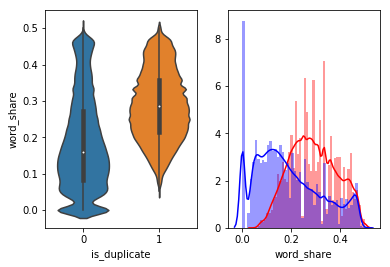

In [150]:
plt.figure()

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

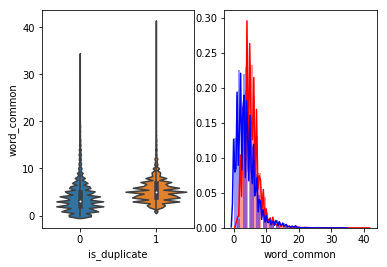

In [153]:
plt.figure()

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()